# Arboles de Clasificacion y Regresion 

In [1]:
from sklearn.datasets import load_iris
from sklearn import tree

from sklearn.model_selection import train_test_split

iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=0)

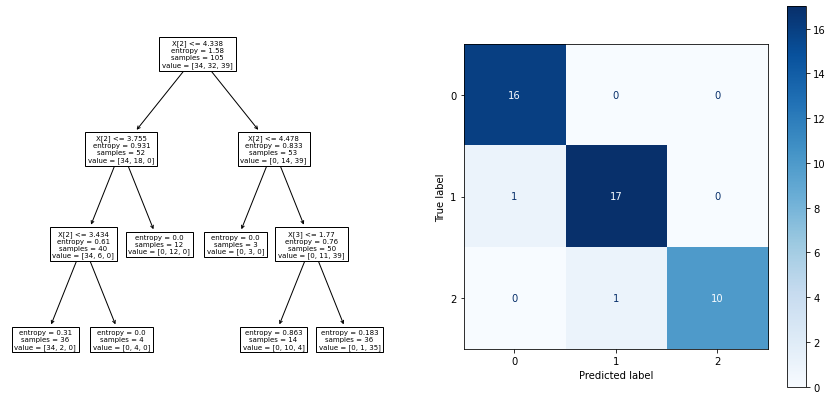

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,roc_auc_score

clf = tree.DecisionTreeClassifier(random_state=None,criterion='entropy',splitter='random',max_depth=3)

clf = clf.fit(X_train, y_train)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,7))
tree.plot_tree(clf,ax=ax1)
plot_confusion_matrix(clf, X_test, y_test,cmap=plt.cm.Blues,ax=ax2)
plt.show()

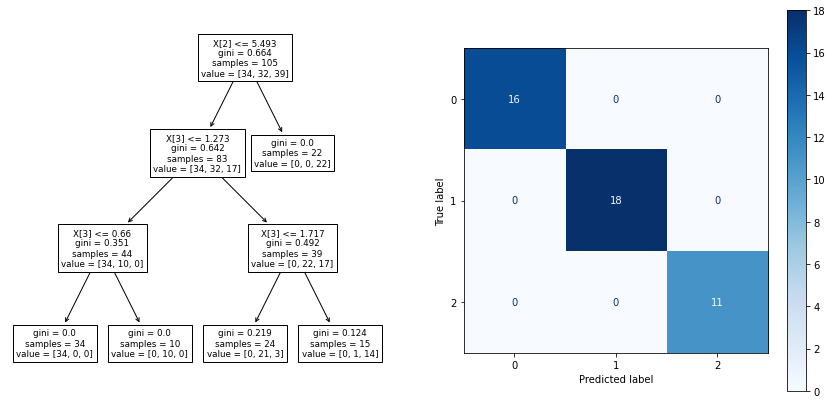

In [20]:
clf = tree.DecisionTreeClassifier(random_state=None,criterion='gini',splitter='random',max_depth=3)
iris = load_iris()

clf = clf.fit(X_train,y_train)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,7))
tree.plot_tree(clf,ax=ax1)
plot_confusion_matrix(clf, X_test, y_test,cmap=plt.cm.Blues,ax=ax2)
plt.show()

# Tarea

En este laboratorio Ud debe completar las siguientes tareas:


1.   Implementar un modelo de arbol para predecir la supervivencia de un paciente infectado con COVID usando datos epidemiologicos (Datos obtenidos desde [1]).
2. Reportar la metrica de ajuste del modelo base.
3. Reportar la metrica de ajuste del modelo usando ensambles.

[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7306186/#!po=54.1667

In [21]:
import pandas as pd

patient_info=pd.read_csv('https://raw.githubusercontent.com/sherna90/mineria_datos/master/data/datasets_527325_1332417_PatientInfo.csv')
#patient_info=pd.read_csv('data/datasets_527325_1332417_PatientInfo.csv')

In [22]:
patient_info.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [24]:
patient_info['confirmed_date']=pd.to_datetime(patient_info['confirmed_date'],format='%Y/%m/%d')
patient_info['released_date']=pd.to_datetime(patient_info['released_date'],format='%Y/%m/%d')
patient_info['deceased_date']=pd.to_datetime(patient_info['deceased_date'],format='%Y/%m/%d')

patient_info['sex'] = patient_info['sex'].astype('category')
patient_info['age'] = patient_info['age'].astype('category')
patient_info['infection_case'] = patient_info['infection_case'].astype('category')

In [25]:
patient_info.drop(columns=['country','province','city','infected_by','contact_number','symptom_onset_date'],inplace=True)

In [26]:
patient_info['state'] = patient_info['state'].astype('category')

In [27]:
data=patient_info.loc[(patient_info['state']=='released') | (patient_info['state']=='deceased')]

In [28]:
data.head()

,patient_id,sex,age,infection_case,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,overseas inflow,2020-01-23,2020-02-05,NaT,released
1,1000000002,male,30s,overseas inflow,2020-01-30,2020-03-02,NaT,released
2,1000000003,male,50s,contact with patient,2020-01-30,2020-02-19,NaT,released
3,1000000004,male,20s,overseas inflow,2020-01-30,2020-02-15,NaT,released
4,1000000005,female,20s,contact with patient,2020-01-31,2020-02-24,NaT,released


In [29]:
data.shape

(3007, 8)

In [30]:
days_released=data.loc[data['state']=='released']['released_date']-data.loc[data['state']=='released']['confirmed_date']

(array([191., 598., 494., 194.,  63.,  23.,  11.,   1.,   2.,   2.]),
 array([  0. ,  11.4,  22.8,  34.2,  45.6,  57. ,  68.4,  79.8,  91.2,
        102.6, 114. ]),
 <a list of 10 Patch objects>)

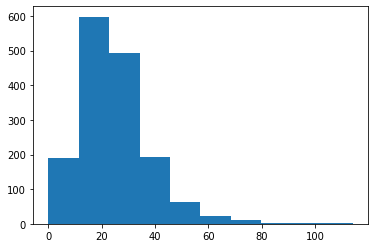

In [37]:
plt.hist(days_released.dt.days)

In [38]:
days_deceased=data.loc[data['state']=='deceased']['deceased_date']-data.loc[data['state']=='deceased']['confirmed_date']

(array([32., 18.,  7.,  1.,  1.,  2.,  1.,  3.,  0.,  1.]),
 array([-1. ,  5.8, 12.6, 19.4, 26.2, 33. , 39.8, 46.6, 53.4, 60.2, 67. ]),
 <a list of 10 Patch objects>)

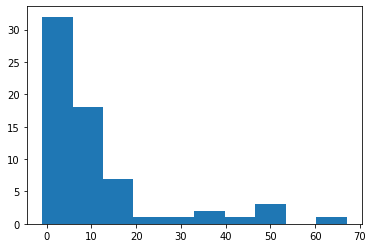

In [39]:
plt.hist(days_deceased.dt.days)

In [40]:
days_deceased

12         NaT
108        NaT
284        NaT
472        NaT
996        NaT
         ...  
4903    3 days
4904   -1 days
4905    1 days
4906    3 days
4957       NaT
Length: 78, dtype: timedelta64[ns]

In [41]:
df_days=data.join(days_deceased.fillna(method='bfill').fillna(method='ffill').rename('no_days'))

In [42]:
df_days

,patient_id,sex,age,infection_case,confirmed_date,released_date,deceased_date,state,no_days
0,1000000001,male,50s,overseas inflow,2020-01-23,2020-02-05,NaT,released,NaT
1,1000000002,male,30s,overseas inflow,2020-01-30,2020-03-02,NaT,released,NaT
2,1000000003,male,50s,contact with patient,2020-01-30,2020-02-19,NaT,released,NaT
3,1000000004,male,20s,overseas inflow,2020-01-30,2020-02-15,NaT,released,NaT
4,1000000005,female,20s,contact with patient,2020-01-31,2020-02-24,NaT,released,NaT
...,...,...,...,...,...,...,...,...,...
5157,7000000012,female,20s,overseas inflow,2020-04-03,2020-05-05,NaT,released,NaT
5158,7000000013,female,10s,overseas inflow,2020-04-14,2020-04-26,NaT,released,NaT
5159,7000000014,female,30s,Itaewon Clubs,2020-05-09,2020-06-12,NaT,released,NaT
5160,7000000015,female,30s,overseas inflow,2020-05-30,2020-06-13,NaT,released,NaT


In [43]:
df_days.loc[df_days.state=='released','no_days']=days_released.copy()

In [44]:
df_days.drop(columns=['confirmed_date','released_date','deceased_date'],inplace=True)

In [45]:
s=df_days.loc[df_days.state=='released',:].isna().any(axis=1)
index_nan=[i for i in s.index if s[i]]

In [46]:
df_days.drop(index_nan,inplace=True)

In [47]:
df_days.shape

(1075, 6)

In [48]:
df_days.loc[df_days.state=='released',:].isna().sum()

patient_id        0
sex               0
age               0
infection_case    0
state             0
no_days           0
dtype: int64

In [49]:
df_days.loc[df_days.state=='deceased',:].isna().sum()

patient_id         0
sex                3
age                3
infection_case    42
state              0
no_days            0
dtype: int64

In [50]:
df_days.loc[df_days.state=='deceased',:]

,patient_id,sex,age,infection_case,state,no_days
12,1000000013,male,80s,contact with patient,deceased,5 days
108,1000000109,male,90s,contact with patient,deceased,5 days
284,1000000285,male,40s,Guro-gu Call Center,deceased,5 days
472,1000000473,male,60s,contact with patient,deceased,5 days
996,1000000997,NaN,NaN,NaN,deceased,5 days
...,...,...,...,...,...,...
4903,6020100107,male,60s,Cheongdo Daenam Hospital,deceased,3 days
4904,6020100205,female,50s,Cheongdo Daenam Hospital,deceased,-1 days
4905,6020100286,male,60s,Cheongdo Daenam Hospital,deceased,1 days
4906,6020100298,male,50s,Cheongdo Daenam Hospital,deceased,3 days


In [51]:
df_days.fillna(method='ffill',inplace=True)

In [ ]:
#df_days.drop(columns=['infection_case'],inplace=True)

In [52]:
df_days.loc[df_days.state=='deceased',:].isna().sum()

patient_id        0
sex               0
age               0
infection_case    0
state             0
no_days           0
dtype: int64

In [53]:
df_days.fillna(method='ffill',inplace=True)

In [ ]:
df_days['released']

# Arbol de Clasificacion

In [131]:
from sklearn.model_selection import train_test_split

X=df_days[['sex','age','infection_case']]
X=pd.get_dummies(X,sparse=True)
X['no_days'] = df_days['no_days'].dt.days.copy()
y=df_days['state']



In [132]:
df_days['sex'].unique()

['male', 'female']
Categories (2, object): ['male', 'female']

In [133]:
X.shape

(1075, 65)

In [128]:
df_days.columns

Index(['patient_id', 'sex', 'age', 'infection_case', 'state', 'no_days'], dtype='object')

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

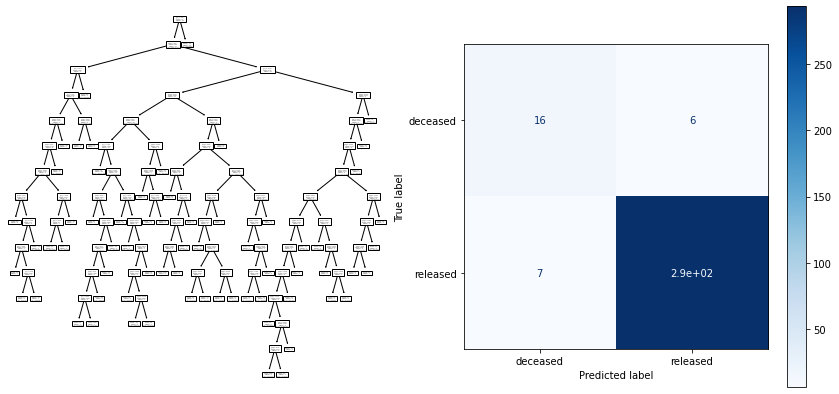

In [66]:
clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='random',class_weight='balanced')

clf = clf.fit(X_train, y_train)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,7))
tree.plot_tree(clf,ax=ax1)
plot_confusion_matrix(clf, X_test, y_test,cmap=plt.cm.Blues,ax=ax2)
plt.show()

In [87]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred=clf.predict(X_test)

print(classification_report(y_test, y_pred))
print('Accuracy : {}'.format(accuracy_score(y_test,y_pred)))

              precision    recall  f1-score   support

    deceased       0.70      0.73      0.71        22
    released       0.98      0.98      0.98       301

    accuracy                           0.96       323
   macro avg       0.84      0.85      0.84       323
weighted avg       0.96      0.96      0.96       323

Accuracy : 0.9597523219814241


In [90]:
confusion_matrix(y_test,y_pred)[0,0]/np.sum(y_test=='deceased')

0.7272727272727273

In [73]:
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np

def gradient_boosting(n,l,d):
  clf = ensemble.GradientBoostingClassifier(max_depth=d,learning_rate=l,n_estimators=n,max_features='auto')
  clf = clf.fit(X_train, y_train)
  y_pred=clf.predict(X_test)
  #print(classification_report(y_test, y_pred))
  return confusion_matrix(y_test,y_pred)[0,0]/np.sum(y_test=='deceased')

In [81]:
n_estimators=[100,300,500]
learning_rate=[0.1,0.01]
max_depth=[2,3,10,20]

estimators_results=[]
lr_results=[]
depth_results=[]
accuracy_results=[]
for (n,l,d) in ((i, j,k) for i in n_estimators for  j in learning_rate for k in max_depth):
  #print('--------------------------------------------------------------------')
  #print('n estimators : {}, learning rate : {}, max depth : {}'.format(n,l,d))
  acc=gradient_boosting(n,l,d)
  estimators_results.append(n)
  lr_results.append(l)
  depth_results.append(d)
  accuracy_results.append(acc)

results=pd.DataFrame({'n_estimators':estimators_results,
                       'max_depth':depth_results,'learning_rate':lr_results,'accuracy_results':accuracy_results})

In [86]:
results.loc[results.accuracy_results==np.max(results.accuracy_results)]

,n_estimators,max_depth,learning_rate,accuracy_results
10,300,10,0.1,0.818182


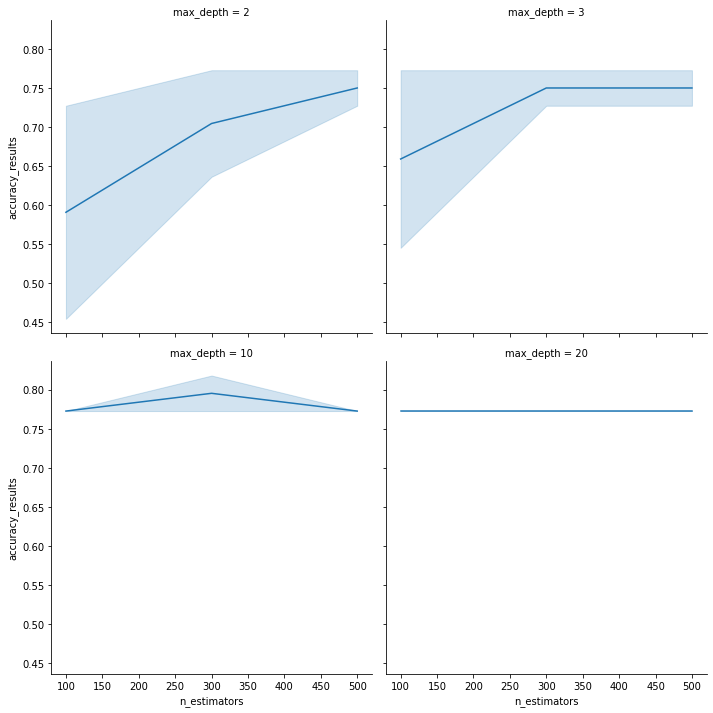

In [83]:
import seaborn as sns

sns.relplot(x="n_estimators", y="accuracy_results",
            col="max_depth",kind="line", legend="full",col_wrap=2, data=results)

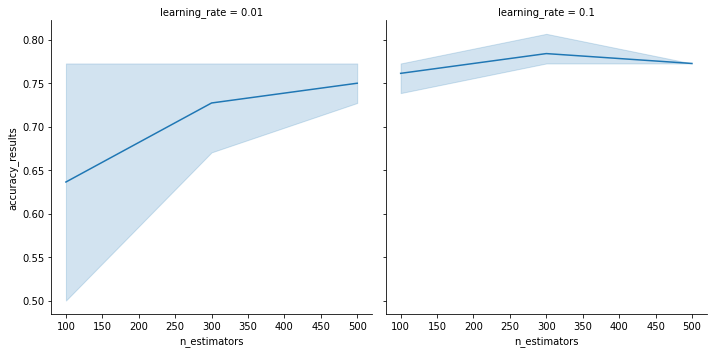

In [85]:
sns.relplot(x="n_estimators", y="accuracy_results",
            col="learning_rate",kind="line", legend="full",col_wrap=2, data=results)

In [129]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=None, shuffle=True)
kf.get_n_splits(X)



5

In [134]:
from sklearn.ensemble import GradientBoostingClassifier

k_fold=0
gboost=list()
for train_index, test_index in kf.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1,max_depth=10, random_state=0).fit(X_train, y_train)
  acc=clf.score(X_test, y_test)
  print('Fold : {}, accuracy : {}'.format(k_fold,acc))
  k_fold+=1
  gboost.append(acc)

Fold : 0, accuracy : 0.9488372093023256
Fold : 1, accuracy : 0.9534883720930233
Fold : 2, accuracy : 0.9674418604651163
Fold : 3, accuracy : 0.9627906976744186
Fold : 4, accuracy : 0.958139534883721


In [138]:
k_fold=0
dtree=list()
for train_index, test_index in kf.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',class_weight='balanced').fit(X_train, y_train)
  acc=clf.score(X_test, y_test)
  print('Fold : {}, accuracy : {}'.format(k_fold,acc))
  k_fold+=1
  dtree.append(acc)

Fold : 0, accuracy : 0.9395348837209302
Fold : 1, accuracy : 0.9674418604651163
Fold : 2, accuracy : 0.9534883720930233
Fold : 3, accuracy : 0.9720930232558139
Fold : 4, accuracy : 0.9627906976744186


In [139]:
print('Exactitud promedio Gradient Boosting: {0:0.2f}, Varianza {1:0.4f}'.format(np.mean(gboost),np.var(gboost)))
print('Exactitud promedio Decision Tree: {0:0.2f}, Varianza {1:0.4f}'.format(np.mean(dtree),np.var(dtree)))

Exactitud promedio Gradient Boosting: 0.96, Varianza 0.0000
Exactitud promedio Decision Tree: 0.96, Varianza 0.0001
